In [ ]:
!pip install pandas
!pip install numpy
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import ast

from torchmetrics import Accuracy, F1Score, Precision, Recall
import pandas as pd
import numpy as np
import torch

In [ ]:
emotion_labels = ['radość', 'zaufanie', 'przeczuwanie', 'zdziwienie', 'strach', 'smutek', 'wstręt', 'gniew', 'pozytywny', 'negatywny', 'neutralny']

num_labels = len(emotion_labels)

In [ ]:
macro_prec = Precision(num_labels=num_labels, average="macro", task='multilabel')
macro_recall = Recall(num_labels=num_labels, average="macro", task='multilabel')
micro_prec = Precision(num_labels=num_labels, average="micro", task='multilabel')
micro_recall = Recall(num_labels=num_labels, average="micro", task='multilabel')
macro_f1 = F1Score(num_labels=num_labels, average='macro', task='multilabel')
weighted_f1 = F1Score(num_labels=num_labels, average='weighted', task='multilabel')
micro_f1 = F1Score(num_labels=num_labels, average='micro', task='multilabel')
f1_scores = F1Score(num_labels=num_labels, average='none', task='multilabel')
accuracy = Accuracy(num_labels=num_labels, task='multilabel')

In [ ]:
df = pd.read_excel('ChatGPT Evaluation v2.0.xlsx', sheet_name='12.ClarinEmo')


In [ ]:
def handle_output(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, dict):
        annotations = set()
        for element in x.values():
            [annotations.add(e) for e in element]
        return list(annotations)
    assert(False)

In [ ]:
y_true = []
y_pred = []
indexes = []
for index, row in df.iterrows():
    annotations = ast.literal_eval(row.annotation)
    y_true_example = [[x in anno for x in emotion_labels] for anno in annotations]
    chat_gpt =  ast.literal_eval(row.chatgpt_final)
    sentences = chat_gpt.keys()
    sentences = sorted(sentences)
    y_pred_example = [handle_output(chat_gpt[key]) for key in sentences]
    y_pred_example = [[x in anno for x in emotion_labels] for anno in y_pred_example]
    assert(len(y_pred_example) == len(y_true_example))
    [y_true.append(example) for example in y_true_example]
    [y_pred.append(example) for example in y_pred_example]    

In [ ]:
y_true = torch.Tensor(y_true)
y_pred = torch.Tensor(y_pred)

In [ ]:
f1_names = [k.capitalize() + ' f1:' for k in emotion_labels]
emotion_f1 = dict(zip(f1_names, f1_scores(y_pred, y_true)))

In [ ]:
print('Micro f1:', float(micro_f1(y_pred, y_true) * 100))
print('Macro f1:', float(macro_f1(y_pred, y_true) * 100))
print('Weighted f1:', float(weighted_f1(y_pred, y_true) * 100))
print('Accuracy:', float(accuracy(y_pred, y_true) * 100))
print('Micro precision:', float(micro_prec(y_pred, y_true) * 100))
print('Micro recall:', float(micro_recall(y_pred, y_true) * 100))
print('Macro precision:', float(macro_prec(y_pred, y_true) * 100))
print('Macro recall:', float(macro_recall(y_pred, y_true) * 100))
for key, value in emotion_f1.items():
    print(key, float(value * 100))

Micro f1: 63.874019622802734
Macro f1: 53.23056411743164
Weighted f1: 63.61101150512695
Accuracy: 83.50114440917969
Micro precision: 74.55882263183594
Micro recall: 55.867767333984375
Macro precision: 63.42132568359375
Macro recall: 48.145137786865234
Radość f1: 68.16647338867188
Zaufanie f1: 48.9959831237793
Przeczuwanie f1: 23.863636016845703
Zdziwienie f1: 21.917808532714844
Strach f1: 40.70796203613281
Smutek f1: 56.18811798095703
Wstręt f1: 39.03743362426758
Gniew f1: 61.57518005371094
Pozytywny f1: 79.1814956665039
Negatywny f1: 85.87055969238281
Neutralny f1: 60.031593322753906


Finetuned model averaged on 10 seeds:
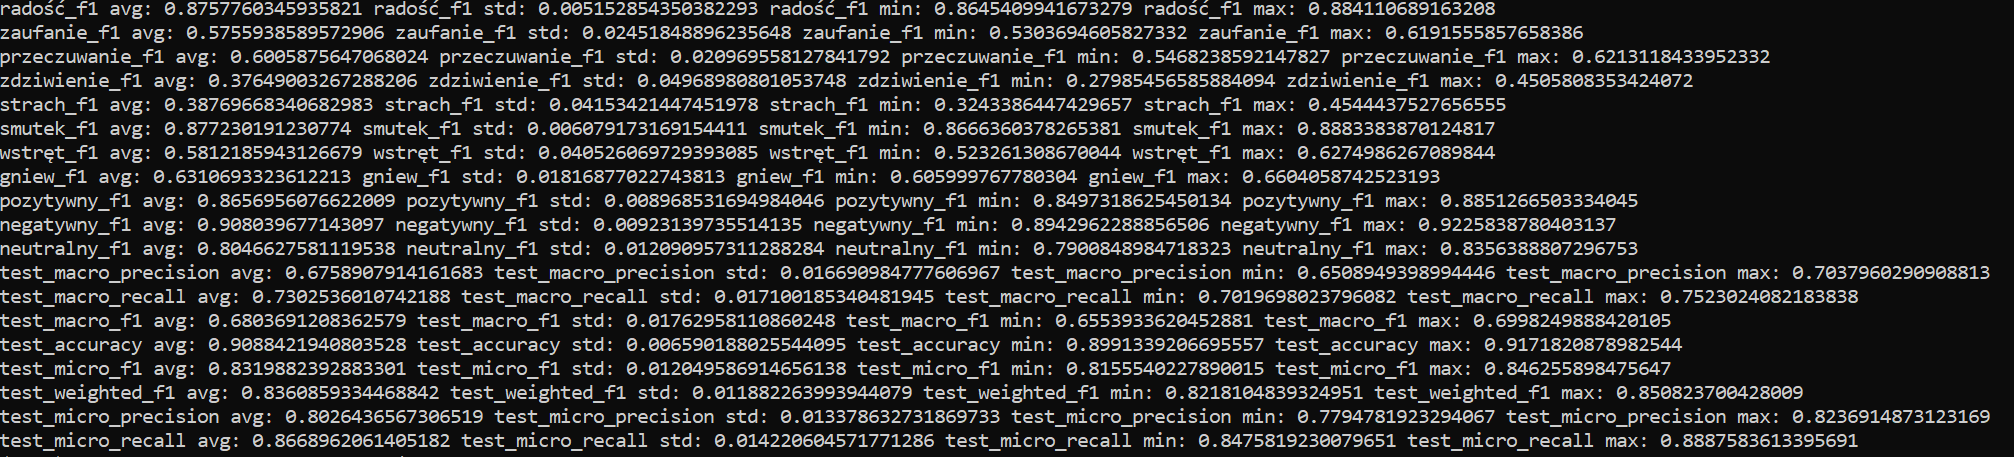

ChatGPT worked worse (in terms of f1 score) on:
*   przeczuwanie (-36.2pp)
*   smutek (-31.5pp)
*   neutralny (-20.5pp)
*   radość (-19.4pp)
*   wstręt (-19.1pp)
*   zdziwienie (-15.7pp)
*   zaufanie (-8.6pp)
*   pozytywny (-7.4pp)
*   negatywny (-4.9pp)
*   gniew (-1.5pp)

ChatGPT worked better on:
*   strach (+1.9pp)


It could be noted that fear is rather common emotion that has the smallest representation in the dataset (only 4.2% of sentences, which is 370 sentences have this label).

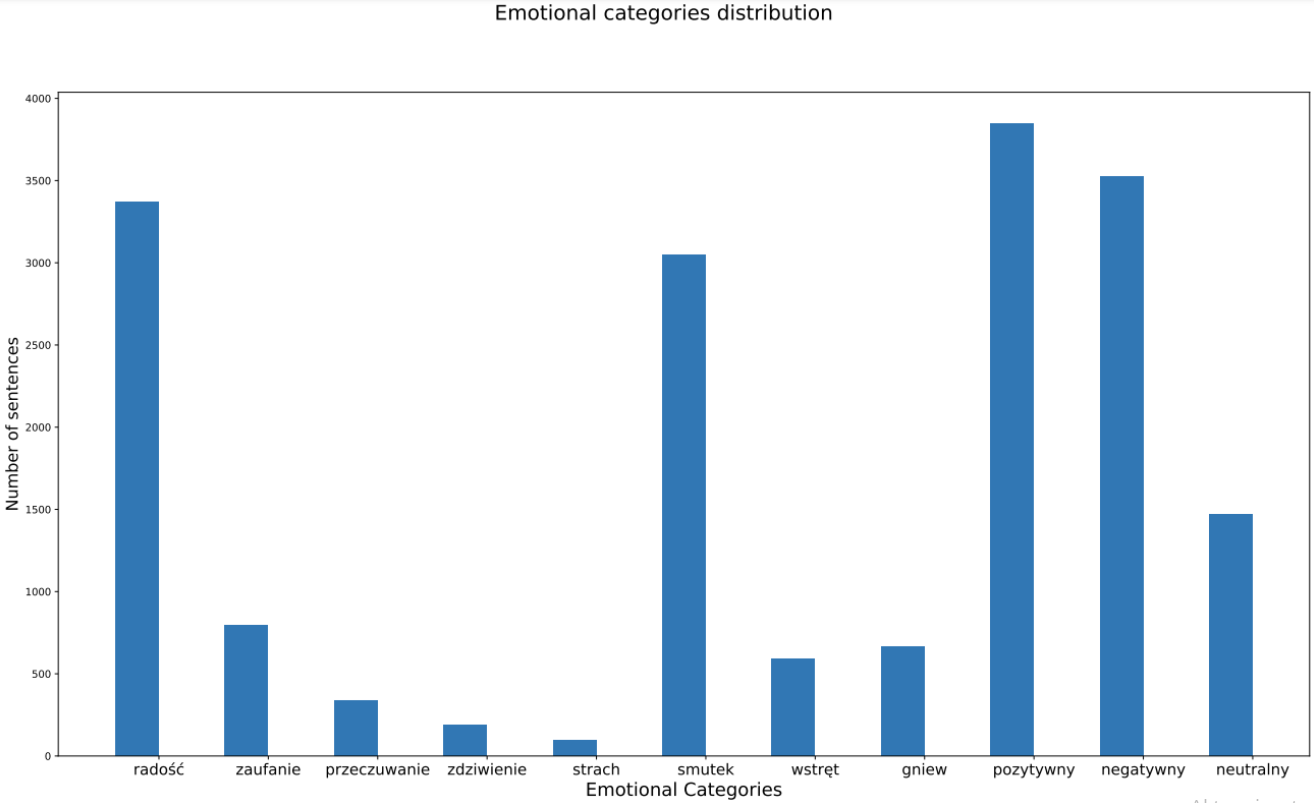